In [1]:
# self-contained version of min-dalle-flax for experimentation purposes.

# this version uses jax.pmap and jit together, and is able to get generation down to 10.1s on 8xA100 for a 4x4 grid using DalleMini (Mega)

# please note that the first few runs are slower (as jax.jit and jax.pmap does its thing a few times to warm up).

import jax, flax
import json
import os
import numpy
from PIL import Image
import torch

from math import inf
from typing import List, Tuple

from functools import partial

from jax import lax, numpy as jnp
from flax import linen as nn

from typing import Dict
from flax.traverse_util import flatten_dict
from flax.serialization import msgpack_restore

import torch
from torch import Tensor
from torch.nn import Module, ModuleList, GroupNorm, Conv2d, Embedding
torch.set_grad_enabled(False)

In [2]:
#os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [3]:
NUM_GPU: int = 8
BATCH_COUNT: int = 16
BATCH_SIZE = 2 # make sure BATCH_SIZE is exactly BATCH_COUNT / NUM_GPU


class ResnetBlock(Module):
  def __init__(self, log2_count_in: int, log2_count_out: int):
    super().__init__()
    m, n = 2 ** log2_count_in, 2 ** log2_count_out
    self.is_middle = m == n
    self.norm1 = GroupNorm(2 ** 5, m)
    self.conv1 = Conv2d(m, n, 3, padding=1)
    self.norm2 = GroupNorm(2 ** 5, n)
    self.conv2 = Conv2d(n, n, 3, padding=1)
    if not self.is_middle:
      self.nin_shortcut = Conv2d(m, n, 1)

  def forward(self, x: Tensor) -> Tensor:
    h = x
    h = self.norm1.forward(h)
    h *= torch.sigmoid(h)
    h = self.conv1.forward(h)
    h = self.norm2.forward(h)
    h *= torch.sigmoid(h)
    h = self.conv2(h)
    if not self.is_middle:
      x = self.nin_shortcut.forward(x)
    return x + h


class AttentionBlock(Module):
  def __init__(self):
    super().__init__()
    n = 2 ** 9
    self.norm = GroupNorm(2 ** 5, n)
    self.q = Conv2d(n, n, 1)
    self.k = Conv2d(n, n, 1)
    self.v = Conv2d(n, n, 1)
    self.proj_out = Conv2d(n, n, 1)

  def forward(self, x: Tensor) -> Tensor:
    n = 2 ** 9
    h = x
    h = self.norm(h)
    q = self.q.forward(h)
    k = self.k.forward(h)
    v = self.v.forward(h)
    q = q.reshape(BATCH_COUNT, n, 2 ** 8)
    q = q.permute(0, 2, 1)
    k = k.reshape(BATCH_COUNT, n, 2 ** 8)
    w = torch.bmm(q, k)
    w /= n ** 0.5
    w = torch.softmax(w, dim=2)
    v = v.reshape(BATCH_COUNT, n, 2 ** 8)
    w = w.permute(0, 2, 1)
    h = torch.bmm(v, w)
    h = h.reshape(BATCH_COUNT, n, 2 ** 4, 2 ** 4)
    h = self.proj_out.forward(h)
    return x + h


class MiddleLayer(Module):
  def __init__(self):
    super().__init__()
    self.block_1 = ResnetBlock(9, 9)
    self.attn_1 = AttentionBlock()
    self.block_2 = ResnetBlock(9, 9)
  
  def forward(self, h: Tensor) -> Tensor:
    h = self.block_1.forward(h)
    h = self.attn_1.forward(h)
    h = self.block_2.forward(h)
    return h


class Upsample(Module):
  def __init__(self, log2_count):
    super().__init__()
    n = 2 ** log2_count
    self.upsample = torch.nn.UpsamplingNearest2d(scale_factor=2)
    self.conv = Conv2d(n, n, 3, padding=1)

  def forward(self, x: Tensor) -> Tensor:
    x = self.upsample.forward(x)
    x = self.conv.forward(x)
    return x


class UpsampleBlock(Module):
  def __init__(
    self, 
    log2_count_in: int, 
    log2_count_out: int, 
    has_attention: bool, 
    has_upsample: bool
  ):
    super().__init__()
    self.has_attention = has_attention
    self.has_upsample = has_upsample
    self.block = ModuleList([
      ResnetBlock(log2_count_in, log2_count_out),
      ResnetBlock(log2_count_out, log2_count_out),
      ResnetBlock(log2_count_out, log2_count_out)
    ])
    if has_attention:
      self.attn = ModuleList([
        AttentionBlock(),
        AttentionBlock(),
        AttentionBlock()
      ])
    else:
      self.attn = ModuleList()

    if has_upsample:
      self.upsample = Upsample(log2_count_out)


  def forward(self, h: Tensor) -> Tensor:
    for j in range(3):
      h = self.block[j].forward(h)
      if self.has_attention:
        h = self.attn[j].forward(h)
    if self.has_upsample:
      h = self.upsample.forward(h)
    return h


class Decoder(Module):
  def __init__(self):
    super().__init__()

    self.conv_in = Conv2d(2 ** 8, 2 ** 9, 3, padding=1)
    self.mid = MiddleLayer()

    self.up = ModuleList([
      UpsampleBlock(7, 7, False, False),
      UpsampleBlock(8, 7, False, True),
      UpsampleBlock(8, 8, False, True),
      UpsampleBlock(9, 8, False, True),
      UpsampleBlock(9, 9, True, True)
    ])

    self.norm_out = GroupNorm(2 ** 5, 2 ** 7)
    self.conv_out = Conv2d(2 ** 7, 3, 3, padding=1)

  def forward(self, z: Tensor) -> Tensor:
    z = self.conv_in.forward(z)
    z = self.mid.forward(z)

    for i in reversed(range(5)):
      z = self.up[i].forward(z)

    z = self.norm_out.forward(z)
    z *= torch.sigmoid(z)
    z = self.conv_out.forward(z)
    return z


class VQGanDetokenizer(Module):
  def __init__(self):
    super().__init__()
    m, n = 2 ** 14, 2 ** 8
    self.embedding = Embedding(m, n)
    self.post_quant_conv = Conv2d(n, n, 1)
    self.decoder = Decoder()

  def forward(self, z: Tensor) -> Tensor:
    z = self.embedding.forward(z)
    z = z.view((BATCH_COUNT, 2 ** 4, 2 ** 4, 2 ** 8))
    z = z.permute(0, 3, 1, 2).contiguous()
    z = self.post_quant_conv.forward(z)
    z = self.decoder.forward(z)
    z = z.permute(0, 2, 3, 1)
    z = z.clip(0.0, 1.0) * 255
    return z

In [4]:
def load_vqgan_torch_params(path: str) -> Dict[str, torch.Tensor]:
  with open(os.path.join(path, 'flax_model.msgpack'), "rb") as f:
    params: Dict[str, numpy.ndarray] = msgpack_restore(f.read())

  P: Dict[str, numpy.ndarray] = flatten_dict(params, sep='.')

  for i in list(P.keys()):
    j = i
    if 'up' in i or 'down' in i:
      j = i.replace('_', '.')
      j = j.replace('proj.out', 'proj_out')
      j = j.replace('nin.short', 'nin_short')
    if 'bias' in i:
      P[j] = P.pop(i)
    elif 'scale' in i:
      j = j.replace('scale', 'weight')
      P[j] = P.pop(i)
    elif 'kernel' in i:
      j = j.replace('kernel', 'weight')
      P[j] = P.pop(i).transpose(3, 2, 0, 1)

  for i in P:
    P[i] = torch.tensor(P[i])

  P['embedding.weight'] = P.pop('quantize.embedding.embedding')

  for i in list(P):
    if i.split('.')[0] in ['encoder', 'quant_conv']:
      P.pop(i)
  
  return P


def load_dalle_bart_flax_params(path: str) -> Dict[str, numpy.ndarray]:
  with open(os.path.join(path, "flax_model.msgpack"), "rb") as f:
    params = msgpack_restore(f.read())

  for codec in ['encoder', 'decoder']:
    k = 'FlaxBart{}Layers'.format(codec.title())
    P: dict = params['model'][codec]['layers'][k]
    P['pre_self_attn_layer_norm'] = P.pop('LayerNorm_0')
    P['self_attn_layer_norm'] = P.pop('LayerNorm_1')
    P['self_attn'] = P.pop('FlaxBartAttention_0')
    if codec == 'decoder':
      P['pre_encoder_attn_layer_norm'] = P.pop('LayerNorm_2')
      P['encoder_attn_layer_norm'] = P.pop('LayerNorm_3')
      P['encoder_attn'] = P.pop('FlaxBartAttention_1')
    P['glu']: dict = P.pop('GLU_0')
    P['glu']['ln0'] = P['glu'].pop('LayerNorm_0')
    P['glu']['ln1'] = P['glu'].pop('LayerNorm_1')
    P['glu']['fc0'] = P['glu'].pop('Dense_0')
    P['glu']['fc1'] = P['glu'].pop('Dense_1')
    P['glu']['fc2'] = P['glu'].pop('Dense_2')

  for codec in ['encoder', 'decoder']:
    layers_params = params['model'][codec].pop('layers')
    params['model'][codec] = {
      **params['model'][codec], 
      **layers_params
    }
  
  model_params = params.pop('model')
  params = {**params, **model_params}

  params['decoder']['lm_head'] = params.pop('lm_head')

  return params


def convert_dalle_bart_torch_from_flax_params(
  params: dict,
  layer_count: int,
  is_encoder: bool
) -> dict:
  P: Dict[str, numpy.ndarray] = flatten_dict(params, sep='.')

  for i in P:
    P[i] = torch.tensor(P[i]).to(torch.float16)

  for i in list(P):
    if 'kernel' in i:
      j = i.replace('kernel', 'weight')
      P[j] = P.pop(i).transpose(-1, -2)
    elif 'scale' in i:
      j = i.replace('scale', 'weight')
      P[j] = P.pop(i)

  for i in list(P):
    j = 'FlaxBart{}Layers'.format('Encoder' if is_encoder else 'Decoder')
    if j in i:
      for l in range(layer_count):
        k = i.replace(j, 'layers.' + str(l))
        P[k] = P[i][l]
      P.pop(i)

  P['embed_tokens.weight'] = P.pop('embed_tokens.embedding')
  P['embed_positions.weight'] = P.pop('embed_positions.embedding')
  return P


def convert_and_save_torch_params(is_mega: bool, model_path: str):
  print("converting params to torch")
  layer_count = 24 if is_mega else 12
  flax_params = load_dalle_bart_flax_params(model_path)
  encoder_params = convert_dalle_bart_torch_from_flax_params(
    flax_params['encoder'],
    layer_count=layer_count,
    is_encoder=True
  )
  decoder_params = convert_dalle_bart_torch_from_flax_params(
    flax_params['decoder'],
    layer_count=layer_count,
    is_encoder=False
  )

  for i in decoder_params:
    decoder_params[i] = decoder_params[i].to(torch.float16)
  
  for i in encoder_params:
    encoder_params[i] = encoder_params[i].to(torch.float16)

  detoker_params = load_vqgan_torch_params('./pretrained/vqgan')
  detoker_path = os.path.join('pretrained', 'vqgan', 'detoker.pt')

  torch.save(encoder_params, os.path.join(model_path, 'encoder.pt'))
  torch.save(decoder_params, os.path.join(model_path, 'decoder.pt'))
  torch.save(detoker_params, detoker_path)

In [5]:
class TextTokenizer:
  def __init__(self, vocab: dict, merges: List[str]):
    self.token_from_subword = vocab
    pairs = [tuple(pair.split()) for pair in merges]
    self.rank_from_pair = dict(zip(pairs, range(len(pairs))))

  def tokenize(self, text: str) -> List[int]:
    sep_token = self.token_from_subword['</s>']
    cls_token = self.token_from_subword['<s>']
    unk_token = self.token_from_subword['<unk>']
    text = text.lower().encode("ascii", errors="ignore").decode()
    tokens = [
      self.token_from_subword.get(subword, unk_token)
      for word in text.split(" ") if len(word) > 0
      for subword in self.get_byte_pair_encoding(word)
    ]
    return [cls_token] + tokens + [sep_token]

  def get_byte_pair_encoding(self, word: str) -> List[str]:
    def get_pair_rank(pair: Tuple[str, str]) -> int:
      return self.rank_from_pair.get(pair, inf)

    subwords = [chr(ord(" ") + 256)] + list(word)
    while len(subwords) > 1:
      pairs = list(zip(subwords[:-1], subwords[1:]))
      pair_to_merge = min(pairs, key=get_pair_rank)
      if pair_to_merge not in self.rank_from_pair: break
      i = pairs.index(pair_to_merge)
      subwords = (
        (subwords[:i] if i > 0 else []) + 
        [subwords[i] + subwords[i + 1]] + 
        (subwords[i + 2:] if i + 2 < len(subwords) else [])
      )

    print(subwords)
    return subwords

In [6]:



class GLUFlax(nn.Module):
  count_in_out: int
  count_middle: int

  def setup(self):
    self.gelu = partial(nn.gelu, approximate=False)
    self.ln0 = nn.LayerNorm(use_scale=False)
    self.ln1 = nn.LayerNorm(use_scale=False)
    self.fc0 = nn.Dense(self.count_middle, use_bias=False)
    self.fc1 = nn.Dense(self.count_middle, use_bias=False)
    self.fc2 = nn.Dense(self.count_in_out, use_bias=False)

  @nn.compact
  def __call__(self, z: jnp.ndarray) -> jnp.ndarray:
    z = self.ln0(z)
    z = self.ln1(self.gelu(self.fc0(z)) * self.fc1(z))
    z = self.fc2(z)
    return z


class AttentionFlax(nn.Module):
  head_count: int
  embed_count: int

  def setup(self):
    self.q_proj = nn.Dense(self.embed_count, use_bias=False)
    self.k_proj = nn.Dense(self.embed_count, use_bias=False)
    self.v_proj = nn.Dense(self.embed_count, use_bias=False)
    self.out_proj = nn.Dense(self.embed_count, use_bias=False)

  def forward(
    self,
    keys: jnp.ndarray,
    values: jnp.ndarray,
    queries: jnp.ndarray,
    attention_mask: jnp.ndarray
  ) -> jnp.ndarray:
    keys = keys.reshape(keys.shape[:2] + (self.head_count, -1))
    values = values.reshape(values.shape[:2] + (self.head_count, -1))
    queries = queries.reshape(queries.shape[:2] + (self.head_count, -1))
    queries /= queries.shape[-1] ** 0.5
    attention_bias: jnp.ndarray = lax.select(
      attention_mask,
      jnp.full(attention_mask.shape, 0.0),
      jnp.full(attention_mask.shape, -jnp.inf),
    )
    attention_weights: jnp.ndarray = jnp.einsum(
      'bqhd,bkhd->bhqk', 
      queries, 
      keys
    )
    attention_weights += attention_bias[:, None, None, :]
    attention_weights = jax.nn.softmax(attention_weights)
    attention_output: jnp.ndarray = jnp.einsum(
      "bhqk,bkhd->bqhd", 
      attention_weights, 
      values
    )
    shape = attention_output.shape[:2] + (self.embed_count,)
    attention_output = attention_output.reshape(shape)
    attention_output = self.out_proj(attention_output)
    return attention_output


class EncoderSelfAttentionFlax(AttentionFlax):
  def __call__(
    self,
    encoder_state: jnp.ndarray,
    attention_mask: jnp.ndarray
  ) -> jnp.ndarray:
    keys = self.k_proj(encoder_state)
    values = self.v_proj(encoder_state)
    queries = self.q_proj(encoder_state)
    return self.forward(keys, values, queries, attention_mask)


class DalleBartEncoderLayerFlax(nn.Module):
  attention_head_count: int
  embed_count: int
  glu_embed_count: int

  def setup(self):
    self.pre_self_attn_layer_norm = nn.LayerNorm(use_scale=False)
    self.self_attn = EncoderSelfAttentionFlax(
      self.attention_head_count,
      self.embed_count
    )
    self.self_attn_layer_norm = nn.LayerNorm()
    self.glu = GLUFlax(self.embed_count, self.glu_embed_count)

  @nn.compact
  def __call__(
    self,
    encoder_state: jnp.ndarray,
    attention_mask: jnp.ndarray
  ) -> jnp.ndarray:
    residual = encoder_state
    encoder_state = self.pre_self_attn_layer_norm(encoder_state)
    encoder_state = self.self_attn(encoder_state, attention_mask)
    encoder_state = self.self_attn_layer_norm(encoder_state)
    encoder_state = residual + encoder_state
    residual = encoder_state
    encoder_state = self.glu(encoder_state)
    encoder_state = residual + encoder_state
    return encoder_state, None


class DalleBartEncoderFlax(nn.Module):
  attention_head_count: int
  embed_count: int
  glu_embed_count: int
  text_token_count: int
  text_vocab_count: int
  layer_count: int

  def setup(self):
    self.embed_tokens = nn.Embed(self.text_vocab_count, self.embed_count)
    self.embed_positions = nn.Embed(self.text_token_count, self.embed_count)
    self.layers = nn.scan(
      DalleBartEncoderLayerFlax,
      variable_axes = { "params": 0 },
      split_rngs = { "params": True },
      in_axes = nn.broadcast,
      length = self.layer_count
    )(
      self.attention_head_count,
      self.embed_count,
      self.glu_embed_count, 
      name="FlaxBartEncoderLayers"
    )
    self.layernorm_embedding = nn.LayerNorm()
    self.final_ln = nn.LayerNorm(use_scale=False)

  def __call__(self, text_tokens: jnp.ndarray) -> jnp.ndarray:
    batch_count, token_count = text_tokens.shape
    pose_tokens = jnp.tile(jnp.arange(token_count), (batch_count, 1))
    attention_mask = jnp.not_equal(text_tokens, 1)
    encoder_state = (
      self.embed_tokens(text_tokens) +
      self.embed_positions(pose_tokens)
    )
    encoder_state = self.layernorm_embedding(encoder_state)
    encoder_state, _ = self.layers(encoder_state, attention_mask)
    encoder_state = self.final_ln(encoder_state)
    return encoder_state

In [7]:
class DecoderCrossAttentionFlax(AttentionFlax):
  def __call__(
    self,
    decoder_state: jnp.ndarray,
    encoder_state: jnp.ndarray,
    attention_mask: jnp.ndarray,
  ) -> jnp.ndarray:
    keys = self.k_proj(encoder_state)
    values = self.v_proj(encoder_state)
    queries = self.q_proj(decoder_state)
    return self.forward(keys, values, queries, attention_mask)


class DecoderSelfAttentionFlax(AttentionFlax):
  def __call__(
    self,
    decoder_state: jnp.ndarray,
    attention_state: jnp.ndarray,
    attention_mask: jnp.ndarray,
    state_index: tuple
  ) -> Tuple[jnp.ndarray, jnp.ndarray]:
    keys = self.k_proj(decoder_state)
    values = self.v_proj(decoder_state)
    queries = self.q_proj(decoder_state)

    attention_state = lax.dynamic_update_slice(
      attention_state, 
      jnp.concatenate([keys, values]).astype(jnp.float32),
      state_index
    )
    batch_count = decoder_state.shape[0]
    keys = attention_state[:batch_count]
    values = attention_state[batch_count:]

    decoder_state = self.forward(
      keys, 
      values,
      queries, 
      attention_mask
    ).astype(decoder_state.dtype)
    return decoder_state, attention_state


class DalleBartDecoderLayerFlax(nn.Module):
  image_token_count: int
  attention_head_count: int
  embed_count: int
  glu_embed_count: int

  def setup(self):
    self.pre_self_attn_layer_norm = nn.LayerNorm(use_scale=False)
    self.self_attn = DecoderSelfAttentionFlax(
      self.attention_head_count,
      self.embed_count
    )
    self.self_attn_layer_norm = nn.LayerNorm()
    self.pre_encoder_attn_layer_norm = nn.LayerNorm(use_scale=False)
    self.encoder_attn = DecoderCrossAttentionFlax(
      self.attention_head_count,
      self.embed_count,
    )
    self.encoder_attn_layer_norm = nn.LayerNorm()
    self.glu = GLUFlax(self.embed_count, self.glu_embed_count)

  @nn.compact
  def __call__(
    self,
    decoder_state: jnp.ndarray,
    encoder_state: jnp.ndarray,
    attention_state: jnp.ndarray,
    attention_mask: jnp.ndarray,
    token_index: int
  ) -> Tuple[jnp.ndarray, jnp.ndarray]:
    # Self Attention
    residual = decoder_state
    decoder_state = self.pre_self_attn_layer_norm(decoder_state)
    self_attention_mask = jnp.tile(
      jnp.arange(self.image_token_count) < token_index + 1, 
      (decoder_state.shape[0], 1)
    )
    decoder_state, attention_state = self.self_attn(
      decoder_state,
      attention_state,
      self_attention_mask,
      (0, token_index, 0)
    )
    decoder_state = self.self_attn_layer_norm(decoder_state)
    decoder_state = residual + decoder_state

    # Cross Attention
    residual = decoder_state
    decoder_state = self.pre_encoder_attn_layer_norm(decoder_state)
    decoder_state = self.encoder_attn(
      decoder_state,
      encoder_state,
      attention_mask
    )
    decoder_state = self.encoder_attn_layer_norm(decoder_state)
    decoder_state = residual + decoder_state

    # Feed forward
    residual = decoder_state
    decoder_state = self.glu(decoder_state)
    decoder_state = residual + decoder_state

    return decoder_state, attention_state


@flax.struct.dataclass
class SampleState:
  prev_token: jnp.ndarray
  prng_key: jnp.ndarray
  attention_state: jnp.ndarray

def super_conditioned(logits: jnp.ndarray, a: float) -> jnp.ndarray:
  return (1 - a) * logits[0, -1] + a * logits[1, -1]

def keep_top_k(logits: jnp.ndarray, k: int) -> jnp.ndarray:
  top_logits, _ = lax.top_k(logits, k)
  suppressed = -jnp.inf * jnp.ones_like(logits)
  return lax.select(logits < top_logits[-1], suppressed, logits)

In [8]:
class DalleBartDecoderFlax(nn.Module):
  image_token_count: int
  image_vocab_count: int
  attention_head_count: int
  embed_count: int
  glu_embed_count: int
  layer_count: int
  start_token: int

  def setup(self):
    self.embed_tokens = nn.Embed(
      self.image_vocab_count + 1,
      self.embed_count
    )
    self.embed_positions = nn.Embed(
      self.image_token_count,
      self.embed_count
    )
    self.layers = nn.scan(
      DalleBartDecoderLayerFlax,
      variable_axes = { "params": 0 },
      split_rngs = { "params": True },
      in_axes = (nn.broadcast, 0, nn.broadcast, nn.broadcast),
      out_axes = 0,
      length=self.layer_count,
    )(
      self.image_token_count,
      self.attention_head_count,
      self.embed_count,
      self.glu_embed_count, 
      name="FlaxBartDecoderLayers"
    )
    self.layernorm_embedding = nn.LayerNorm()
    self.final_ln = nn.LayerNorm(use_scale=False)
    self.lm_head = nn.Dense(self.image_vocab_count + 1, use_bias=False)

  def __call__(
    self,
    encoder_state: jnp.ndarray,
    attention_state: jnp.ndarray,
    attention_mask: jnp.ndarray,
    prev_token: int,
    token_index: int
  ) -> Tuple[jnp.ndarray, jnp.ndarray]:
    batch_count = encoder_state.shape[0]
    ones = jnp.ones((batch_count, 1), dtype=jnp.int32)
    decoder_state = self.embed_tokens(prev_token * ones) 
    decoder_state += self.embed_positions(token_index * ones)
    decoder_state = self.layernorm_embedding(decoder_state)
    decoder_state, attention_state = self.layers(
      decoder_state,
      encoder_state,
      attention_state,
      attention_mask,
      token_index
    )
    decoder_state = self.final_ln(decoder_state)
    decoder_state = self.lm_head(decoder_state)
    return decoder_state, attention_state

  def sample_image_tokens(
    self,
    text_tokens: jnp.ndarray,
    encoder_state: jnp.ndarray,
    prng_key: jax.random.PRNGKey,
    params: dict
  ) -> jnp.ndarray:
    attention_mask = jnp.not_equal(text_tokens, 1)
    
    def sample_next_image_token(
      state: SampleState,
      token_index: int
    ) -> Tuple[SampleState, jnp.ndarray]:
      logits, attention_state = self.apply(
        { 'params': params },
        encoder_state = encoder_state,
        attention_state = state.attention_state,
        attention_mask = attention_mask,
        prev_token = state.prev_token,
        token_index = token_index
      )
      
      logits = super_conditioned(logits, 10.0)
      logits = keep_top_k(logits, k=50)

      prng_key, prng_key_next = jax.random.split(state.prng_key)
      next_token = jax.random.categorical(prng_key, logits, axis=-1)

      state = SampleState(
        prev_token = next_token,
        prng_key = prng_key_next,
        attention_state = attention_state
      )

      return state, next_token

    batch_count = encoder_state.shape[0]
    attention_state_shape = (
      self.layer_count, 
      batch_count * 2, 
      self.image_token_count, 
      self.embed_count
    )

    initial_state = SampleState(
      prev_token = self.start_token,
      prng_key = prng_key,
      attention_state = jnp.zeros(attention_state_shape)
    )

    _, image_tokens = lax.scan(
      sample_next_image_token,
      initial_state,
      jnp.arange(self.image_token_count)
    )     

    return image_tokens

In [54]:
class MinDalleFlax:
  def __init__(self, is_mega: bool, is_reusable: bool = True):
    self.is_mega = is_mega
    model_name = 'dalle_bart_{}'.format('mega' if is_mega else 'mini')
    self.model_path = os.path.join('pretrained', model_name)

    print("reading files from {}".format(self.model_path))
    vocab_path = os.path.join(self.model_path, 'vocab.json')
    merges_path = os.path.join(self.model_path, 'merges.txt')

    with open(vocab_path, 'r', encoding='utf8') as f:
      vocab = json.load(f)
    with open(merges_path, 'r', encoding='utf8') as f:
      merges = f.read().split("\n")[1:-1]
      
    self.tokenizer = TextTokenizer(vocab, merges)

    self.is_reusable = is_reusable
    print("initializing MinDalleFlax")
    self.model_params = load_dalle_bart_flax_params(self.model_path)
    if is_reusable:
      self.init_encoder()
      self.init_decoder()
      self.init_detokenizer()


  def init_encoder(self):
    print("initializing DalleBartEncoderFlax")
    self.encoder_raw: DalleBartEncoderFlax = DalleBartEncoderFlax(
      attention_head_count = 32 if self.is_mega else 16,
      embed_count = 2048 if self.is_mega else 1024,
      glu_embed_count = 4096 if self.is_mega else 2730,
      text_token_count = 64,
      text_vocab_count = 50272 if self.is_mega else 50264,
      layer_count = 24 if self.is_mega else 12
    ).bind({'params': self.model_params.pop('encoder')})
    self.encoder = self.encoder_raw
    

  def init_decoder(self):
    print("initializing DalleBartDecoderFlax")
    self.decoder = DalleBartDecoderFlax(
      image_token_count = 256,
      image_vocab_count = 16415 if self.is_mega else 16384,
      attention_head_count = 32 if self.is_mega else 16,
      embed_count = 2048 if self.is_mega else 1024,
      glu_embed_count = 4096 if self.is_mega else 2730,
      layer_count = 24 if self.is_mega else 12,
      start_token = 16415 if self.is_mega else 16384
    )
    self.batch_decoder_vmap = jax.vmap(self.decoder.sample_image_tokens, in_axes=(None, None, 0, None), out_axes=0)
    self.batch_decoder_vmap_jit = jax.jit(self.batch_decoder_vmap)
    self.batch_decoder_pmap = jax.pmap(self.batch_decoder_vmap_jit, in_axes=(None, None, 0, None), out_axes=0)


  def init_detokenizer(self):
    print("initializing VQGanDetokenizer")
    params = load_vqgan_torch_params('./pretrained/vqgan')
    self.detokenizer = VQGanDetokenizer()
    self.detokenizer.load_state_dict(params)
    del params


  def tokenize_text(self, text: str) -> numpy.ndarray:
    print("tokenizing text")
    tokens = self.tokenizer.tokenize(text)
    print("text tokens", tokens)
    text_tokens = numpy.ones((2, 64), dtype=numpy.int32)
    text_tokens[0, :2] = [tokens[0], tokens[-1]]
    text_tokens[1, :len(tokens)] = tokens
    return text_tokens


  def generate_image(self, text: str, seed: int) -> numpy.ndarray:
    text_tokens = self.tokenize_text(text)

    if not self.is_reusable: self.init_encoder()
    
    print("encoding text tokens")
    encoder_state = self.encoder(text_tokens)
    if not self.is_reusable: del self.encoder

    if not self.is_reusable:
      self.init_decoder()
      params = self.model_params.pop('decoder')
    else:
      params = self.model_params['decoder']
      
    init_key = jax.random.PRNGKey(seed)
    keys = jax.random.split(init_key, BATCH_SIZE*NUM_GPU)
    batch_keys = keys.reshape(NUM_GPU, BATCH_SIZE, 2)

    print("sampling image tokens")
    image_tokens = self.batch_decoder_pmap(
      text_tokens,
      encoder_state,
      batch_keys,
      params
    )
    
    image_tokens = image_tokens.reshape(NUM_GPU*BATCH_SIZE, 256)
    if not self.is_reusable: del self.decoder

    image_tokens = numpy.array(image_tokens)
    print("image_tokens.shape", image_tokens.shape)

    image_tokens = torch.tensor(image_tokens)

    if not self.is_reusable: self.init_detokenizer()
    print("detokenizing image")
    images = self.detokenizer.forward(image_tokens).to(torch.uint8)
    if not self.is_reusable: del self.detokenizer
    images = images.to('cpu').detach().numpy()
    return images

In [55]:
def image_grid(array, ncols=4):
  index, height, width, channels = array.shape
  nrows = index//ncols
  
  img_grid = (array.reshape(nrows, ncols, height, width, channels)
            .swapaxes(1,2)
            .reshape(height*nrows, width*ncols, channels))
  
  return img_grid

In [56]:
image_generator = MinDalleFlax(is_mega=True, is_reusable=True)

reading files from pretrained/dalle_bart_mega
initializing MinDalleFlax
initializing DalleBartEncoderFlax
initializing DalleBartDecoderFlax
initializing VQGanDetokenizer


In [74]:
text = "Jar Jar Binks on Vogue Magazine"
the_seed = 101

In [75]:
%%time
images = image_generator.generate_image(text, the_seed)

tokenizing text
['Ġjar']
['Ġjar']
['Ġbin', 'ks']
['Ġon']
['Ġvogue']
['Ġmagazine']
text tokens [0, 3339, 3339, 5446, 366, 133, 6749, 1115, 2]
encoding text tokens
sampling image tokens
image_tokens.shape (16, 256)
detokenizing image
CPU times: user 2min 20s, sys: 1min 17s, total: 3min 37s
Wall time: 10.1 s


In [76]:
images4x4 = image_grid(images)

In [77]:
image = Image.fromarray(images4x4)

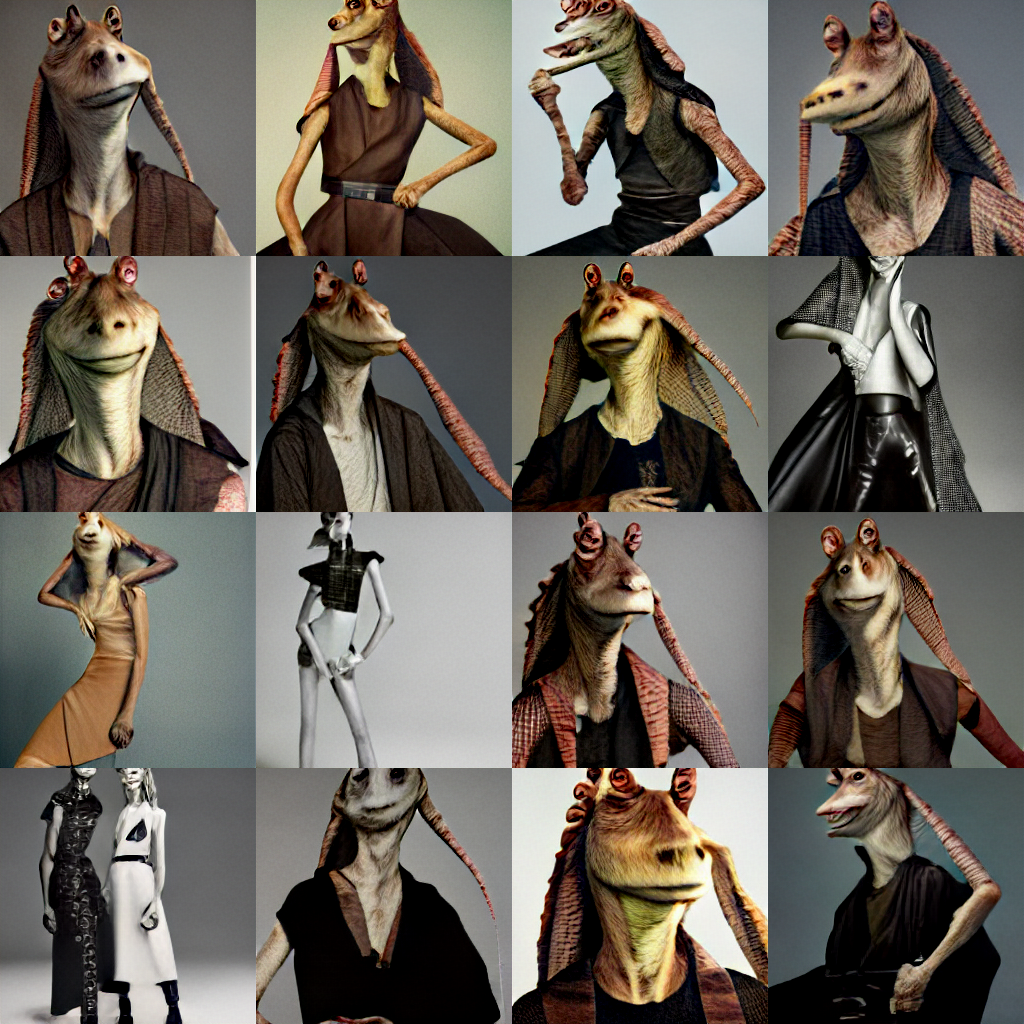

In [78]:
image

In [79]:
image.save("./"+text.replace(" ", "_")+"."+str(the_seed)+".png")